In [1]:
import pandas as pd
import numpy as np
import librosa as lr
import os
import pydot
import graphviz


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM
from keras.utils import plot_model, to_categorical
from os.path import join
from keras.optimizers import Adam


2023-03-27 21:27:01.039821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 21:27:01.120400: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 21:27:01.122826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 21:27:01.122838: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
# Set file directory and create an object for all .wav files
data_dir = os.path.join(os.getcwd(), 'data')
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

In [3]:
patient_diagnosis = pd.read_csv(os.path.join(data_dir, 'patient_diagnosis.csv'), names = ['pid', 'disease'])
patient_diagnosis

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [4]:
file_paths = [os.path.join(data_dir, 'pre_processed_audio', 'audio_4kHz_filtered', f) for f in os.listdir(os.path.join(data_dir, 'pre_processed_audio', 'audio_4kHz_filtered')) if f.endswith('.wav')]
n_fft = 512
hop_length = 512
n_mels = 40

In [5]:
def load_file(file_path, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels):
    features = []
    max_mel = {}
    min_mel = {}
    pad_length = 0

    for file_path in file_paths:
        y, sr = lr.load(file_path)
        mel_spec = lr.feature.melspectrogram(
            y = y,
            sr = sr,
            n_fft = n_fft,
            hop_length = hop_length,
            n_mels = n_mels)
        max_mel, min_mel = np.amax(mel_spec), np.amin(mel_spec)
        normalized_mel_spec = (mel_spec - min_mel) / (max_mel - min_mel)
        pad_length = max(pad_length, normalized_mel_spec.shape[1])
        features.append(mel_spec)
    return features, max_mel, min_mel, pad_length

In [6]:
features_tmp, max_mel, min_mel, pad_length = load_file(file_paths)


In [7]:
def mel_padding(mel, pad_length):
    time_diff = pad_length - mel.shape[1]
    left_pad = time_diff // 2
    right_pad = time_diff - left_pad
    padded_mel = np.pad(mel, ((0, 0), (left_pad, right_pad)),
                        mode='constant', constant_values=0)
    return padded_mel

In [8]:
padded_features = []

for mel in features_tmp:
    padded_features.append(mel_padding(mel, pad_length))

In [9]:
features_stack = np.dstack(padded_features)
features_stack.shape

(40, 3713, 920)

In [10]:
def array_reshape(X):
    d1, d2, d3 = X.shape
    X = X.reshape((d3, d1, d2, 1))
    return X

In [11]:
labels = []
features = []
specs_list = []

for file in file_paths:
    pid = int(file.split('/')[-1].split('_')[0])
    labels.append(patient_diagnosis.loc[patient_diagnosis["pid"] == pid, "disease"].iloc[0]) # Get disease for corresponding pid
labels_final = np.array(labels)

In [12]:
disease_dict = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
labels_new = [disease_dict[d] for d in labels_final]
print(labels_new)
labels = np.array(labels_new)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 

In [13]:
index_to_remove = np.where((labels == 7) | (labels == 6))
features = np.delete(features_stack, index_to_remove, axis = 2) 
labels = np.delete(labels, index_to_remove, axis = 0)
print(features.shape)
print(labels.shape)

(40, 3713, 917)
(917,)


In [14]:
features = array_reshape(features)
features.shape

(917, 40, 3713, 1)

In [15]:
from imblearn.under_sampling import RandomUnderSampler
    

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=10)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



In [16]:
input_shape = (40, 3713, 1)
model = Sequential()
model.add(Conv2D(8, kernel_size=(2, 2), activation="relu",
          input_shape=input_shape, dilation_rate=2))

model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', dilation_rate=2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', dilation_rate=2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(loss="binary_crossentropy",
              optimizer='adam', metrics=["accuracy"])
model.summary()
history = model.fit(X_train, y_train, batch_size=64,
                    epochs=10, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 3711, 8)       40        
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 3709, 16)      528       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 1854, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 1852, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 926, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 926, 32)        0

2023-03-27 21:27:23.324637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 21:27:23.324717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 21:27:23.324755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-27 21:27:23.324779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-27 21:27:23.324803: W tensorf

Epoch 1/10
12/12 [==============================] - 12s 988ms/step - loss: 0.3355 - accuracy: 0.8445 - val_loss: 0.2547 - val_accuracy: 0.8370
Epoch 2/10
12/12 [==============================] - 12s 974ms/step - loss: 0.1826 - accuracy: 0.8745 - val_loss: 0.2426 - val_accuracy: 0.8370
Epoch 3/10
12/12 [==============================] - 12s 974ms/step - loss: 0.1614 - accuracy: 0.8772 - val_loss: 0.2204 - val_accuracy: 0.8370
Epoch 4/10
 6/12 [==============>...............] - ETA: 5s - loss: 0.1530 - accuracy: 0.8776

KeyboardInterrupt: 

6/6 [==============================] - 1s 195ms/step
                precision    recall  f1-score   support

          COPD       0.84      0.99      0.91       154
       Healthy       0.00      0.00      0.00         8
          URTI       0.00      0.00      0.00         6
Bronchiectasis       0.00      0.00      0.00         2
     Pneumonia       0.00      0.00      0.00        11
 Bronchiolitis       0.00      0.00      0.00         3

      accuracy                           0.83       184
     macro avg       0.14      0.17      0.15       184
  weighted avg       0.70      0.83      0.76       184



/home/raghav1881/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raghav1881/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raghav1881/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: xlabel='Predicted', ylabel='Actual'>

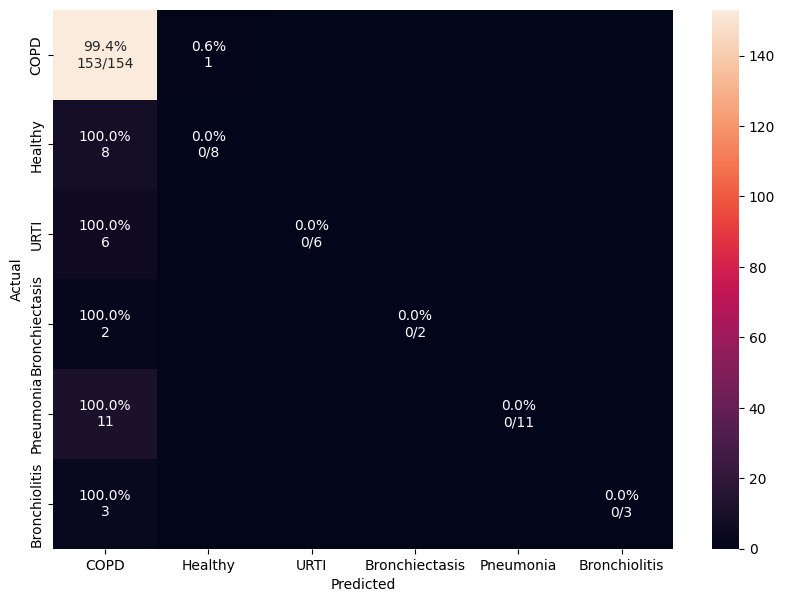

In [ ]:
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')